In [36]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
plt.rc('font', family='Malgun Gothic')
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
import xgboost
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
from utils import *

In [2]:
seed_everything(42)

In [3]:
path = './data/'
train = open_csv(path, 'train').drop('num_date_time', axis=1)
test = open_csv(path, 'test').drop('num_date_time', axis=1)
building = open_csv(path, 'building_info')
submission = open_csv(path, 'sample_submission')

In [4]:
display(train.head(2), test.head(2), building.head(2))

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36


,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1,20220825 00,23.5,0.0,2.2,72
1,1,20220825 01,23.0,0.0,0.9,72


,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.0,-,-,-
1,2,건물기타,122233.47,99000.0,-,-,-


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   건물번호        204000 non-null  int64  
 1   일시          204000 non-null  object 
 2   기온(C)       204000 non-null  float64
 3   강수량(mm)     43931 non-null   float64
 4   풍속(m/s)     203981 non-null  float64
 5   습도(%)       203991 non-null  float64
 6   일조(hr)      128818 non-null  float64
 7   일사(MJ/m2)   116087 non-null  float64
 8   전력소비량(kWh)  204000 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 14.0+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   건물번호     16800 non-null  int64  
 1   일시       16800 non-null  object 
 2   기온(C)    16800 non-null  float64
 3   강수량(mm)  16800 non-null  float64
 4   풍속(m/s)  16800 non-null  float64
 5   습도(%)    16800 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 787.6+ KB


In [7]:
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [8]:
train.describe(include='object').T

,count,unique,top,freq
일시,204000,2040,20220601 00,100


In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
건물번호,204000.0,50.500000,28.866141,1.0,25.75,50.50,75.25,100.00
기온(C),204000.0,25.543524,3.779523,10.1,23.40,25.70,28.10,37.10
강수량(mm),43931.0,2.040830,5.165218,0.0,0.00,0.10,1.30,92.20
풍속(m/s),203981.0,2.134031,1.358109,0.0,1.20,2.00,2.80,13.30
습도(%),203991.0,78.716295,15.080108,13.0,69.00,81.00,91.00,100.00
일조(hr),128818.0,0.333637,0.401486,0.0,0.00,0.10,0.70,1.00
일사(MJ/m2),116087.0,1.063823,1.001030,0.0,0.20,0.71,1.78,3.92
전력소비량(kWh),204000.0,2451.036462,2440.648858,0.0,1085.76,1766.40,2970.00,25488.40


In [10]:
test.describe(include='object').T

,count,unique,top,freq
일시,16800,168,20220825 00,100


In [11]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
건물번호,16800.0,50.500000,28.866929,1.0,25.75,50.5,75.25,100.0
기온(C),16800.0,21.975232,2.884010,12.2,19.90,21.7,23.60,32.3
강수량(mm),16800.0,0.266720,1.130288,0.0,0.00,0.0,0.00,18.8
풍속(m/s),16800.0,1.783405,1.041896,0.0,1.00,1.7,2.50,7.0
습도(%),16800.0,77.148036,16.080725,26.0,66.75,79.0,90.00,100.0


In [12]:
building.describe(include='object').T

,count,unique,top,freq
건물유형,100,12,건물기타,15
태양광용량(kW),100,33,-,64
ESS저장용량(kWh),100,6,-,95
PCS용량(kW),100,5,-,95


In [13]:
building.describe().T

,count,mean,std,min,25%,50%,75%,max
건물번호,100.0,50.50000,2.901149e+01,1.0,25.75,50.50,75.2500,100.0
연면적(m2),100.0,260887.52831,1.279963e+06,5578.4,61446.12,92640.50,184813.5000,12872877.0
냉방면적(m2),100.0,186403.23680,1.090638e+06,0.0,23187.00,55823.36,99150.9675,10941945.0


In [14]:
split_datetime(train, '일시', datetime=False)
split_datetime(test, '일시', datetime=False)

In [15]:
train.drop(['일조(hr)', '일사(MJ/m2)'], axis=1, inplace=True)

In [16]:
train.fillna(0, inplace=True)

In [17]:
na_cols = building.columns[-3:]
for col in na_cols:
    building[col] = building[col].replace('-', 0)
    building[col] = building[col].astype(float)

In [18]:
encoder = LabelEncoder()
building['건물유형'] = encoder.fit_transform(building['건물유형'])

In [19]:
train = pd.merge(train, building, how='left')
test = pd.merge(test, building, how='left')

In [20]:
val = train[np.logical_and(train['month']==8, train['day']>=18)]
train = train.drop(index=val.index)

In [21]:
train_x = train.drop('전력소비량(kWh)', axis=1)
train_y = train['전력소비량(kWh)']
val_x = val.drop('전력소비량(kWh)', axis=1)
val_y = val['전력소비량(kWh)']

In [22]:
model = XGBRegressor(random_state=42)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [23]:
preds = model.predict(val_x)
print(f'SMAPE : {SMAPE(val_y, preds)}')

SMAPE : 5.4205084576696985


In [24]:
preds = model.predict(test)
submission['answer'] = preds

In [25]:
submission.to_csv('./submissions/230808_xgboost.csv', index=False)

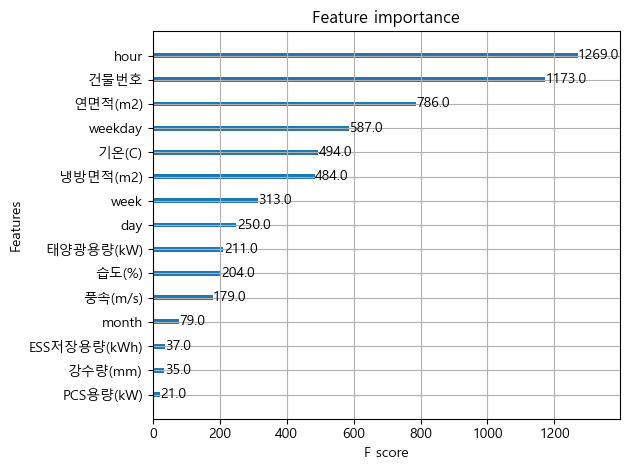

In [26]:
xgboost.plot_importance(model)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [27]:
train_x['태양광유무'] = train_x['태양광용량(kW)']>0
train_x['ESS유무'] = train_x['ESS저장용량(kWh)']>0
train_x['PCS유무'] = train_x['PCS용량(kW)']>0

val_x['태양광유무'] = val_x['태양광용량(kW)']>0
val_x['ESS유무'] = val_x['ESS저장용량(kWh)']>0
val_x['PCS유무'] = val_x['PCS용량(kW)']>0

In [28]:
train_x['태양광유무'] = train_x['태양광유무'].astype(int)
train_x['ESS유무'] = train_x['ESS유무'].astype(int)
train_x['PCS유무'] = train_x['PCS유무'].astype(int)
val_x['태양광유무'] = val_x['태양광유무'].astype(int)
val_x['ESS유무'] = val_x['ESS유무'].astype(int)
val_x['PCS유무'] = val_x['PCS유무'].astype(int)

In [29]:
train_x.drop(['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'], axis=1, inplace=True)
val_x.drop(['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'], axis=1, inplace=True)

In [30]:
model = XGBRegressor(random_state=42)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [31]:
preds = model.predict(val_x)
print(f'SMAPE : {SMAPE(val_y, preds)}')

SMAPE : 5.435501032004699


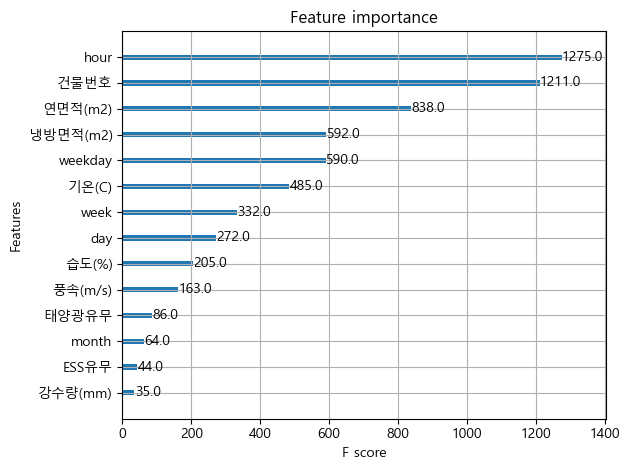

In [32]:
xgboost.plot_importance(model)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [33]:
test['태양광유무'] = test['태양광용량(kW)']>0
test['ESS유무'] = test['ESS저장용량(kWh)']>0
test['PCS유무'] = test['PCS용량(kW)']>0

In [34]:
test['태양광유무'] = test['태양광유무'].astype(int)
test['ESS유무'] = test['ESS유무'].astype(int)
test['PCS유무'] = test['PCS유무'].astype(int)
test.drop(['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'], axis=1, inplace=True)

In [35]:
preds = model.predict(test)
submission['answer'] = preds
submission.to_csv('./submissions/230808_xgboost(2).csv', index=False)

In [37]:
model = LGBMRegressor(random_state=42)
model.fit(train_x, train_y)
preds = model.predict(val_x)
print(f'SMAPE : {SMAPE(val_y, preds)}')

SMAPE : 6.441000919414345


In [38]:
preds = model.predict(test)
submission['answer'] = preds
submission.to_csv('./submissions/230808_lightgbm.csv', index=False)